## Importing Libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline


## Getting Data for repo (Note: downloading 20k rct data to find the best preforming model)



In [2]:
##Getting Train data for rct 20k
! wget https://raw.githubusercontent.com/average-joe25/scientific-abstract-classifier/main/data/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt
##Getting validation data for rct 20k
! wget https://raw.githubusercontent.com/average-joe25/scientific-abstract-classifier/main/data/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt
## Getting test data for rct 20k
! wget https://raw.githubusercontent.com/average-joe25/scientific-abstract-classifier/main/data/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt

--2022-05-05 10:19:29--  https://raw.githubusercontent.com/average-joe25/scientific-abstract-classifier/main/data/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28908792 (28M) [text/plain]
Saving to: ‘train.txt’

train.txt           100%[===================>]  27.57M  --.-KB/s    in 0.1s    

2022-05-05 10:19:31 (245 MB/s) - ‘train.txt’ saved [28908792/28908792]

--2022-05-05 10:19:31--  https://raw.githubusercontent.com/average-joe25/scientific-abstract-classifier/main/data/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubuserco

In [3]:
## moving them to new folder
! mkdir rct20k
! mv dev.txt rct20k/
! mv train.txt rct20k/
! mv test.txt rct20k/

## EDA and visualization of Data

In [4]:
##Getting lines from the files
def get_data(dataset_type,rct_type):
  parent_folder='/content/'
  with open(str(parent_folder+rct_type+"/"+dataset_type),'r') as f:
    list_lines= f.readlines()
    return list_lines

In [21]:
train_lines_20k=get_data("train.txt","rct20k")
test_lines_20k=get_data("test.txt","rct20k")
val_lines_20k=get_data("dev.txt","rct20k")

In [22]:
len(train_lines_20k),len(test_lines_20k),len(val_lines_20k)

(210040, 35135, 35212)

In [23]:
## function to create dataframe from lines
def convert_to_df(lines):
  abstract_size=0
  dict_list=[]
  abstract=[]
  list_abstract=[]
  for line in lines:
    if(line.startswith("###")):
      if(len(abstract)!=0):
        list_abstract.append(abstract)
      abstract=[]
    else:
      abstract.append(line)
  list_abstract.append(abstract)
  for new_abstract in list_abstract:
    count=0
    for line in new_abstract:
      count+=1
      splitted=line.split('\t')
      if(splitted[0]=='\n'):
        continue
      category=splitted[0]
      text=splitted[1]
      dict_list.append({'target':category,'text':text,'location':float(count/len(new_abstract))})
  list_df=pd.DataFrame(dict_list)
  return list_df


In [24]:
##convert lines to dataframe
train_df=convert_to_df(train_lines_20k)
val_df=convert_to_df(val_lines_20k)
test_df=convert_to_df(test_lines_20k)

In [32]:
train_df.head(15)

,target,text,location
0,0,To investigate the efficacy of @ weeks of dail...,0.076923
1,1,A total of @ patients with primary knee OA wer...,0.153846
2,1,Outcome measures included pain reduction and i...,0.230769
3,1,Pain was assessed using the visual analog pain...,0.307692
4,1,Secondary outcome measures included the Wester...,0.384615
5,1,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",0.461538
6,2,There was a clinically relevant reduction in t...,0.538462
7,2,The mean difference between treatment arms ( @...,0.615385
8,2,"Further , there was a clinically relevant redu...",0.692308
9,2,These differences remained significant at @ we...,0.769231


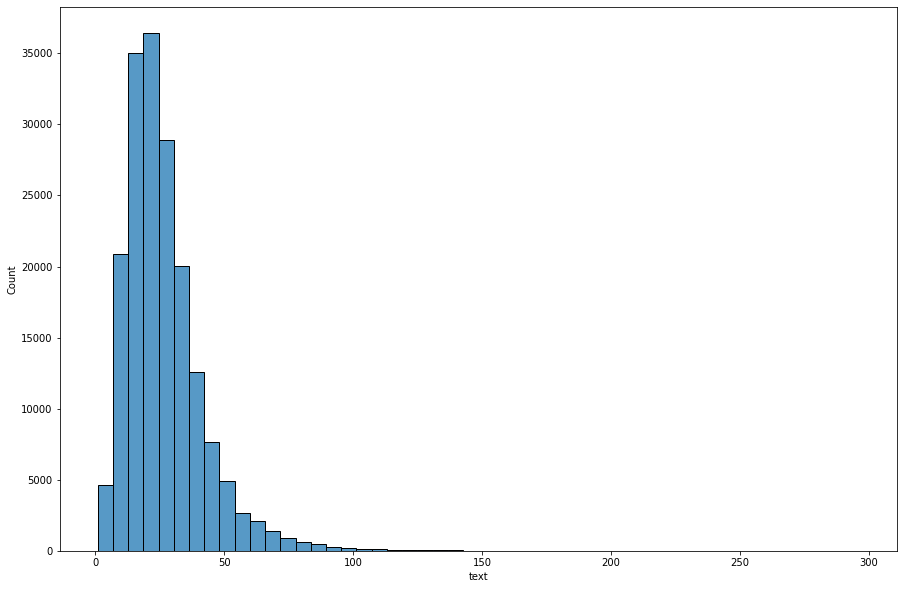

In [26]:
#length line in a abstract
plt.figure(figsize=(15,10))
sns.histplot(x=train_df['text'].apply(lambda x: len(x.split(' '))),bins=50)

In [ ]:
## one hot Encoding The  classes
num_classes=train_df['target'].nunique()
class_names=list(train_df['target'].unique())
train_df['target']=train_df['target'].apply(lambda x: class_names.index(x))
def onehotencoding(data,classes):
  return tf.one_hot(data,classes)
train_labels=onehotencoding(train_df['target'],num_classes)

In [36]:
test_df['target']=test_df['target'].apply(lambda x: class_names.index(x))
val_df['target']=val_df['target'].apply(lambda x: class_names.index(x))
test_labels=onehotencoding(test_df['target'],num_classes)
val_labels=onehotencoding(val_df['target'],num_classes)

## Turning DataFrame to tf.data.dataset for faster computing 

In [39]:
from tensorflow.data import Dataset

In [40]:
train_dataset=Dataset.from_tensor_slices((train_df['text'].to_numpy(),train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=Dataset.from_tensor_slices((test_df['text'].to_numpy(),test_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset=Dataset.from_tensor_slices((val_df['text'].to_numpy(),val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [73]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

##Modelling using conv1D

In [42]:
from tensorflow.keras import layers

In [77]:
## creating text vectorizer
text_vec = layers.TextVectorization(output_sequence_length=50)
text_vec.adapt(train_df['text'])
## creating embedding
txt_embed = layers.Embedding(len(text_vec.get_vocabulary()),256,mask_zero=True,name="token_embedding")

In [87]:
##creating model
text_input=layers.Input(shape=(1,),name='input_layer',dtype=tf.string)
x=text_vec(text_input)
x=txt_embed(x)
x=layers.Conv1D(64,5,padding='same')(x)
x=layers.MaxPool1D(5,padding='same')(x)
x=layers.Conv1D(64,5,padding='same')(x)
x=layers.MaxPool1D(5,padding='same')(x)
x=layers.GlobalAveragePooling1D()(x)
x=layers.Dense(10,activation='relu')(x)
output=layers.Dense(num_classes,activation='softmax')(x)





In [88]:
model1=tf.keras.Model(text_input,output)
model1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer='adam',metrics=['accuracy'])

In [89]:
model1.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization_5 (TextV  (None, 50)               0         
 ectorization)                                                   
                                                                 
 token_embedding (Embedding)  (None, 50, 256)          16599296  
                                                                 
 conv1d_10 (Conv1D)          (None, 50, 64)            81984     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 10, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 10, 64)            2054

In [90]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
earlystop=EarlyStopping(monitor='val_accuracy',patience=5,mode='max',verbose=0,restore_best_weights=True)

In [ ]:
# Training on only 10% of the data
model1.fit(train_dataset,steps_per_epoch=int(0.1*len(train_dataset)),epochs=100,validation_data=val_dataset,validation_steps=int(0.1*(len(val_dataset))),callbacks=[earlystop])

## Evaluation

In [93]:
from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score
def measure(pred,value):
  eva_dict={'accuracy':accuracy_score(value,pred),'precision':precision_score(value,pred,average='weighted'),'recall':recall_score(value,pred,average='weighted'),'f1_score':f1_score(value,pred,average='weighted')}
  print(eva_dict)

In [94]:
model1.evaluate(val_dataset)

945/945 [==============================] - 8s 8ms/step - loss: 0.4800 - accuracy: 0.8234


[0.48002520203590393, 0.8233814239501953]

In [95]:
pred=model1.predict(test_df['text'])

In [100]:
pred=tf.argmax(pred,axis=1)

In [103]:
measure(pred,test_df['target'])

{'accuracy': 0.8160610585697694, 'precision': 0.8185812373828328, 'recall': 0.8160610585697694, 'f1_score': 0.812620223587036}
